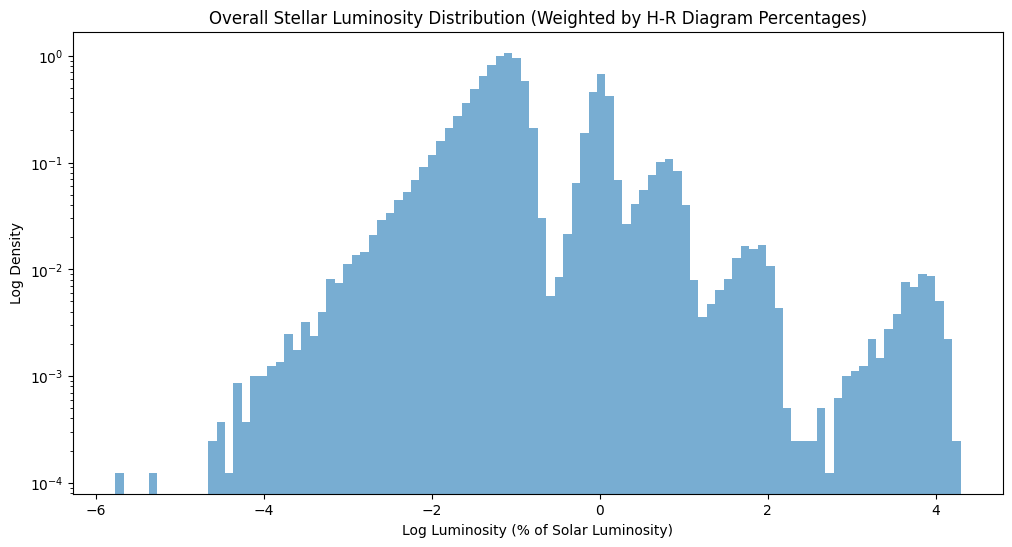

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import math

# Key for random sampling
key = jax.random.PRNGKey(42)

# Define star types with their radius ranges and H-R diagram percentages
star_types_luminosity = [
    {"name": "Red Dwarfs", "mean": 0.05, "std": 0.0499, "weight": 0.70},       # 0.01% - 10%
    {"name": "Sun-like Stars", "mean": 1.0, "std": 0.25, "weight": 0.15},     # 10% - 200%
    {"name": "Blue Giants", "mean": 5, "std": 3, "weight": 0.05},         # 200% - 1000%
    {"name": "Red Giants", "mean": 50, "std": 40, "weight": 0.01},        # 1000% - 10,000%
    {"name": "Supergiants", "mean": 5000, "std": 4000, "weight": 0.005}, # 10,000% - 1,000,000%
]

# Total number of samples
total_samples = 100000

# Sample from each star type based on their percentage
samples = []
for i, star in enumerate(star_types_luminosity):
    num_samples = int(total_samples * (star["weight"]))
    key, subkey = jax.random.split(key)
    star_samples = jax.random.normal(subkey, (num_samples,)) * star["std"] + star["mean"]

    star_samples = [x for x in star_samples if x >= 0]

    star_samples = jnp.array([math.log(x, 10) for x in star_samples])

    samples.extend(star_samples)

# Combine all samples into one array
target_luminosity = jax.numpy.array(samples)

# Plot the overall distribution
plt.figure(figsize=(12, 6))
plt.hist(target_luminosity, bins=100, density=True, alpha=0.6)
plt.title("Overall Stellar Luminosity Distribution (Weighted by H-R Diagram Percentages)")
plt.xlabel("Log Luminosity (% of Solar Luminosity)")
plt.ylabel("Log Density")
plt.yscale('log')
plt.show()

In [ ]:
import math

# Brightness of a star in terms of the sun's brightness
def brightnessFromRadius(r, t):
  return r*r*t*t*t*t

def transform(d, e):
  d = jnp.asarray(d)
  e = jnp.asarray(e)
  return jnp.log10(brightnessFromRadius((jnp.power(10, d)), (jnp.power(10, e))))


In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
def kl_divergence(p, q):
    epsilon = 1e-8
    p += epsilon
    q += epsilon
    return jnp.sum(p * (jnp.log(p) - jnp.log(q)))

# Optimization Loop
from jax import grad

learning_rate = 0.01


In [ ]:
from jax import grad, value_and_grad
from jax.scipy.stats import norm
import numpy as np

allow optimization to change means/deviation

allow "labels" to float across distributions

as it is, input distributions cannot match the output

investigate what different weights output

In [ ]:
star_types_radius = [
    {"name": "Red Dwarfs", "mean": 0.3, "std": 0.2},
    {"name": "Sun-like Stars", "mean": 1.0, "std": 0.1},
    {"name": "Blue Giants", "mean": 5.0, "std": 2.0},
    {"name": "Red Giants", "mean": 50.0, "std": 20.0},
    {"name": "Supergiants", "mean": 500.0, "std": 200.0},
]

star_types_temperature = [
    {"name": "Red Dwarfs", "mean": 0.5, "std": 0.05},  # ~3000K, ~0.3 T_sun
    {"name": "Sun-like Stars", "mean": 1.0, "std": 0.1},  # ~5800K, 1.0 T_sun
    {"name": "Blue Giants", "mean": 5.0, "std": 1.0},  # ~30,000K, ~5 T_sun
    {"name": "Red Giants", "mean": 0.5, "std": 0.1},  # ~3000K, ~0.5 T_sun
    {"name": "Supergiants", "mean": 2.0, "std": 1},  # 3500K - 20,000K, ~1.0 T_sun (varies widely)
]

In [ ]:
import optax

In [ ]:
from jax.scipy.stats import norm

def skew_normal(samples, key, alpha, loc=0.0, scale=1.0):
    delta = alpha / jnp.sqrt(1 + alpha**2)

    auxiliary_samples = jax.random.normal(key, shape=samples.shape)

    # Combine the original and auxiliary samples to introduce skewness
    skewed = delta * samples + jnp.sqrt(1 - delta**2) * auxiliary_samples
    skewed = jnp.where(samples > 0, skewed, -skewed)  # Conditional transformation for skewness

    # Apply location and scale transformations
    return loc + scale * skewed

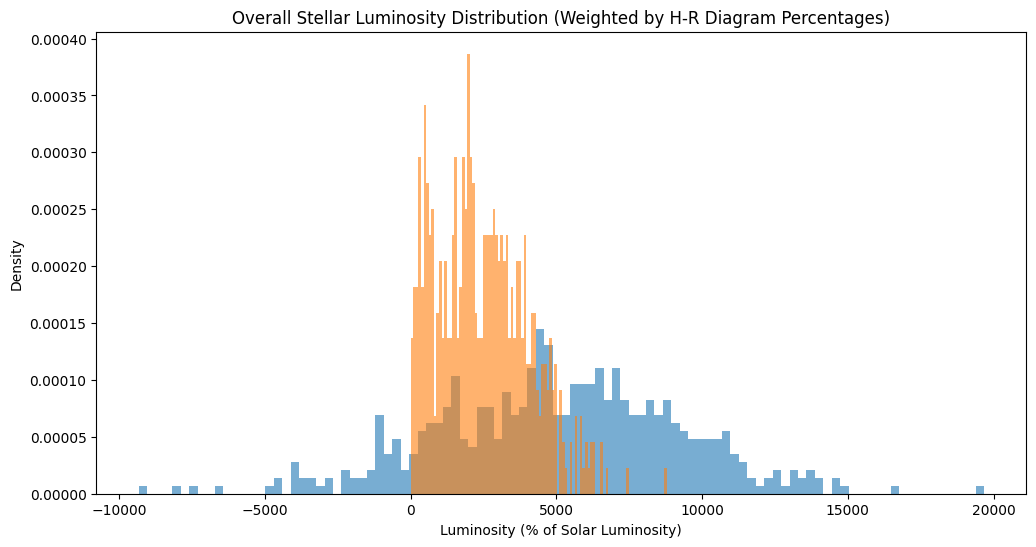

In [ ]:
star_samples = jax.random.normal(subkey, (num_samples,)) * star["std"] + star["mean"]

skewed_star_samples = skew_normal(star_samples, key, 0.5, loc=0.0, scale=1.0)

plt.figure(figsize=(12, 6))
plt.hist(star_samples, bins=100, density=True, alpha=0.6)
plt.hist(skewed_star_samples, bins=100, density=True, alpha=0.6)
plt.title("Overall Stellar Luminosity Distribution (Weighted by H-R Diagram Percentages)")
plt.xlabel("Luminosity (% of Solar Luminosity)")
plt.ylabel("Density")
plt.show()

In [ ]:
from jax import random

In [ ]:
params = {
    "weights": jnp.array([1.0/7.0, 1.0/7.0, 1.0/7.0, 1.0/7.0, 1.0/7.0]),
    #"temp_skews": jnp.array([0.0, 0.0, 0.0, 0.0, 0.0]),
    #"rad_skews": jnp.array([0.0, 0.0, 0.0, 0.0, 0.0]),
    "rad_means": random.uniform(key, shape=(1, 5), minval=-2, maxval=2)[0],
    "temp_means": random.uniform(key, shape=(1, 5), minval=0, maxval=1)[0],
    "rad_stds": random.uniform(key, shape=(1, 5), minval=0.5, maxval=2)[0],
    "temp_stds": random.uniform(key, shape=(1, 5), minval=0.5, maxval=1)[0],
}

print(params)

total_samples = 100000

key = jax.random.PRNGKey(42)

PDFS2 = []

for i, star in enumerate(star_types_luminosity):
    key, subkey = jax.random.split(key)
    num_samples = int(total_samples * 1.0/7.0)

    star_samples = jax.random.normal(subkey, (num_samples,)) * star["std"] + star["mean"]
    star_samples = jnp.clip(star_samples, star['mean'] - star['std'], star['mean'] + star['std'])
    star_samples = jnp.log10(star_samples)

    PDFS2.append(jax.scipy.stats.gaussian_kde(star_samples))

x = jnp.linspace(-5, 5, 100)

target_luminosity = jnp.zeros_like(x)

for i in range(len(PDFS2)):
    target_luminosity += PDFS2[i](x) * star_types_luminosity[i]['weight']

def normalize_weights(weights):
    return jax.nn.softmax(weights)

# Loss Function
def loss_fn(params):
    #luminosity = forward(star_types_radius, params
    PDFS = []
    key = jax.random.PRNGKey(42)

    for i, star in enumerate(star_types_radius):
        key, subkey = jax.random.split(key)
        num_samples = int(total_samples * 1.0/7.0)

        star_samples_rad = jax.random.normal(subkey, (num_samples,)) * params["rad_stds"][i] + params["rad_means"][i]
        #star_samples_rad = jnp.clip(star_samples_rad, max(1e-5, params["rad_means"][i] - params["rad_stds"][i]), max(1e-5, params["rad_means"][i] + params["rad_stds"][i]))
        #star_samples_rad = jnp.log10(star_samples_rad)
        #star_samples_rad = skew_normal(star_samples_rad, key, params['rad_skews'][i])

        star_temp = star_types_temperature[i]

        star_samples_temp = jax.random.normal(subkey, (num_samples,)) * params["temp_stds"][i] + params["temp_means"][i]
        #star_samples_temp = jnp.clip(star_samples_temp, max(1e-5, params["temp_means"][i] - params["temp_stds"][i]), max(1e-5, params["temp_means"][i] + params["temp_stds"][i]))
        #star_samples_temp = jnp.log10(star_samples_temp)
        #star_samples_temp = skew_normal(star_samples_temp, key, params['temp_skews'][i])

        star_samples = transform(star_samples_rad, star_samples_temp)

        PDFS.append(jax.scipy.stats.gaussian_kde(star_samples))

    params['weights'] = jax.nn.softmax(params['weights'])

    # Compare distributions using KDE
    kde_radii = jnp.zeros_like(x)

    for i in range(len(PDFS)):
        kde_radii += PDFS[i](x) * params['weights'][i]

    p = kde_radii
    q = target_luminosity

    p = p / (jnp.sum(p) + 1e-8)
    q = q / (jnp.sum(q) + 1e-8)

    # KL Divergence
    return kl_divergence(p, q)

# Optimization Loo

# Initialize the optimizer
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params)

# Training Loop with Adaptive Learning Rate
for i in range(500):
    loss, grads = value_and_grad(loss_fn)(params)

    # Apply updates using the optimizer
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


    # Ensure weights remain normalized
    #params["weights"] = normalize_weights(params["weights"])

    print(f"Iteration {i}: Loss = {loss:.4f}")
    print("Weights:")
    for weight in params['weights']:
        print(weight)
    print("")

    if loss < 0.01:
        break

params['weights'] = jax.nn.softmax(params['weights'])

key = jax.random.PRNGKey(42)

kde_radii = jnp.zeros_like(x)

PDFS = []
key = jax.random.PRNGKey(42)

for i, star in enumerate(star_types_radius):
  key, subkey = jax.random.split(key)
  num_samples = int(total_samples * 1.0/7.0)

  star_samples_rad = jax.random.normal(subkey, (num_samples,)) * params["rad_stds"][i] + star["mean"]
  star_samples_rad = jnp.clip(star_samples_rad, max(1e-5, star['mean'] - params["rad_stds"][i]), star['mean'] + params["rad_stds"][i])
  star_samples_rad = jnp.log10(star_samples_rad)
  star_samples_rad = skew_normal(star_samples_rad, key, params['skews'][i])

  star_temp = star_types_temperature[i]

  star_samples_temp = jax.random.normal(subkey, (num_samples,)) * params["temp_stds"][i] + star_temp["mean"]
  star_samples_temp = jnp.clip(star_samples_temp, max(1e-5, star['mean'] - params["temp_stds"][i]), star_temp['mean'] + params["temp_stds"][i])
  star_samples_temp = jnp.log10(star_samples_temp)
  star_samples_temp = skew_normal(star_samples_temp, key, params['skews'][i])

  star_samples = transform(star_samples_rad, star_samples_temp)

  PDFS.append(jax.scipy.stats.gaussian_kde(star_samples))

for i in range(len(PDFS)):
    kde_radii += PDFS[i](x) * params['weights'][i]

p = kde_radii
q = target_luminosity

p = p / jnp.sum(p)
q = q / jnp.sum(q)

plt.figure(figsize=(12, 6))
plt.plot(x, p, label='Final Luminosity Distribution')
plt.plot(x, q, label='Target Luminosity Distribution')
plt.legend()
plt.show()

{'weights': Array([0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715],      dtype=float32), 'rad_means': Array([ 0.85148764, -0.0124402 ,  1.251564  ,  1.9110274 ,  0.7377362 ],      dtype=float32), 'temp_means': Array([0.7128719 , 0.49688995, 0.812891  , 0.97775686, 0.68443406],      dtype=float32), 'rad_stds': Array([1.5693078, 1.2453349, 1.7193365, 1.9666352, 1.5266511], dtype=float32), 'temp_stds': Array([0.85643595, 0.748445  , 0.9064455 , 0.9888784 , 0.842217  ],      dtype=float32)}
Iteration 0: Loss = 4.4243
Weights:
0.13285723
0.15285708
0.13285722
0.13285722
0.13285726

Iteration 1: Loss = 4.4027
Weights:
0.12287736
0.16285561
0.122858346
0.12285581
0.12289697

Iteration 2: Loss = 4.3818
Weights:
0.112929106
0.17285196
0.11286102
0.112852335
0.11299812

Iteration 3: Loss = 4.3619
Weights:
0.10302222
0.18284523
0.102865875
0.10284678
0.10317639

Iteration 4: Loss = 4.3427
Weights:
0.09316358
0.19283484
0.09287323
0.092839286
0.09343636

Iteration 5: Loss = 4.3242
Weig

KeyError: 'skews'

In [ ]:
print(params)

{'rad_means': Array([-0.3453576 , -0.320918  , -0.17703004, -0.22845936, -0.21716227],      dtype=float32), 'rad_stds': Array([0.22749898, 0.0495947 , 0.02572632, 0.0391855 , 0.2760162 ],      dtype=float32), 'temp_means': Array([-0.34535763, -0.32091805, -0.17703004, -0.22845933, -0.21716224],      dtype=float32), 'temp_stds': Array([0.22749886, 0.04959453, 0.02572616, 0.03918553, 0.27601624],      dtype=float32), 'weights': Array([0.16937898, 0.1768734 , 0.23896076, 0.24617459, 0.16861226],      dtype=float32)}


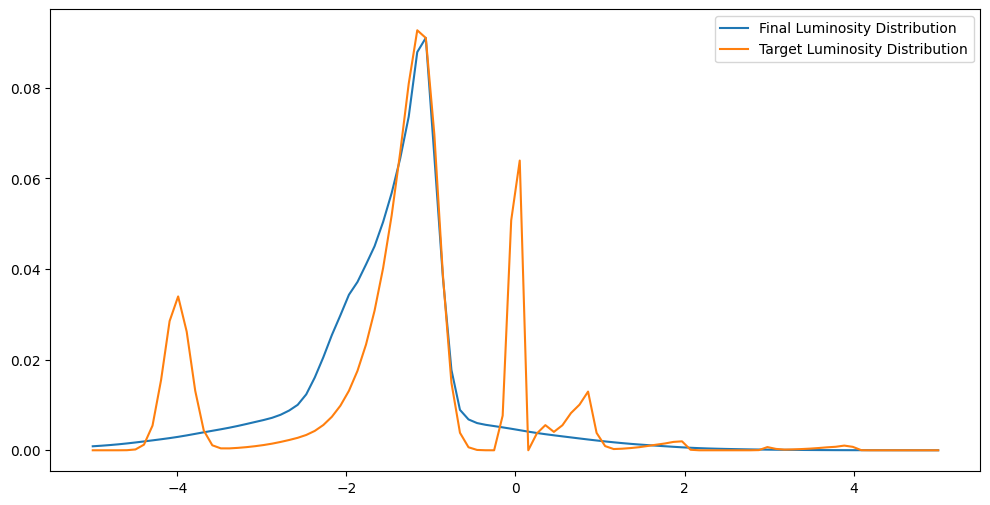

In [ ]:
num_samples = int(total_samples * 1.0/7.0)
PDFS = []
key = jax.random.PRNGKey(42)

kde_radii = jnp.zeros_like(x)

for i, star in enumerate(star_types_radius):
    key, subkey = jax.random.split(key)
    num_samples = int(total_samples * 1.0/7.0)

    star_samples_rad = jax.random.normal(subkey, (num_samples,)) * params["rad_stds"][i] + params["rad_means"][i]
    #star_samples_rad = jnp.clip(star_samples_rad, max(1e-5, params["rad_means"][i] - params["rad_stds"][i]), max(1e-5, params["rad_means"][i] + params["rad_stds"][i]))
    #star_samples_rad = jnp.log10(star_samples_rad)
    #star_samples_rad = skew_normal(star_samples_rad, key, params['rad_skews'][i])

    star_temp = star_types_temperature[i]

    star_samples_temp = jax.random.normal(subkey, (num_samples,)) * params["temp_stds"][i] + params["temp_means"][i]
    #star_samples_temp = jnp.clip(star_samples_temp, max(1e-5, params["temp_means"][i] - params["temp_stds"][i]), max(1e-5, params["temp_means"][i] + params["temp_stds"][i]))
    #star_samples_temp = jnp.log10(star_samples_temp)
    #star_samples_temp = skew_normal(star_samples_temp, key, params['temp_skews'][i])

    star_samples = transform(star_samples_rad, star_samples_temp)

    PDFS.append(jax.scipy.stats.gaussian_kde(star_samples))

params['weights'] = jax.nn.softmax(params['weights'])

# Compare distributions using KDE
kde_radii = jnp.zeros_like(x)

for i in range(len(PDFS)):
    kde_radii += PDFS[i](x) * params['weights'][i]

p = kde_radii
q = target_luminosity

p = p / jnp.sum(p)
q = q / jnp.sum(q)

plt.figure(figsize=(12, 6))
plt.plot(x, p, label='Final Luminosity Distribution')
plt.plot(x, q, label='Target Luminosity Distribution')
plt.legend()
plt.show()

[0.86317176 0.31318107 0.30562145 ... 0.75924844 0.575357   0.52192855]


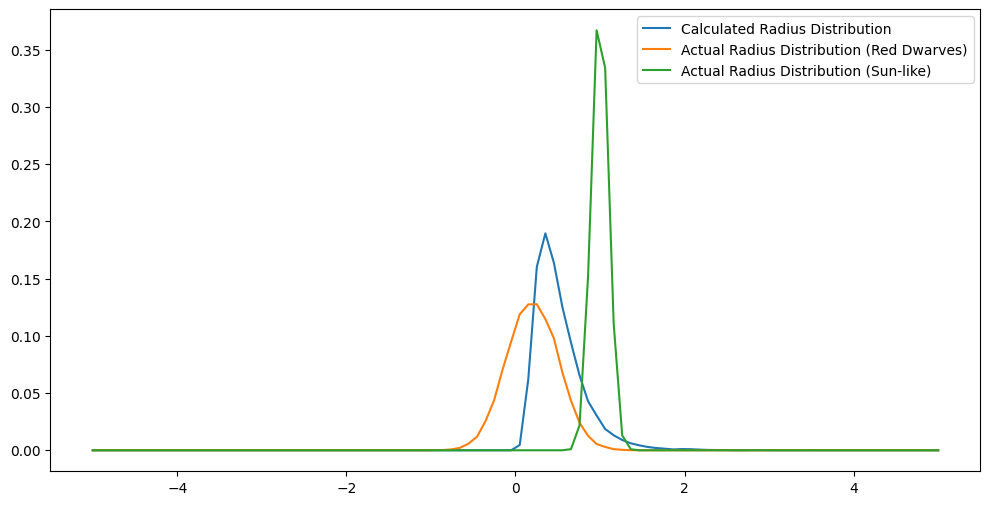

[0.51136607 0.44087896 0.44896424 ... 0.41790736 0.47745597 0.39477122]


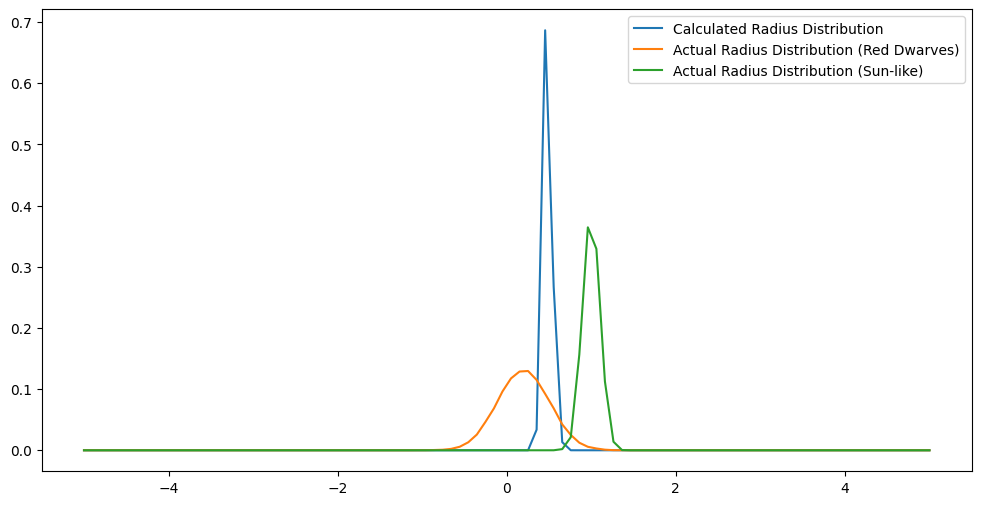

[0.62177104 0.6399365  0.6660404  ... 0.70923346 0.67192674 0.7306213 ]


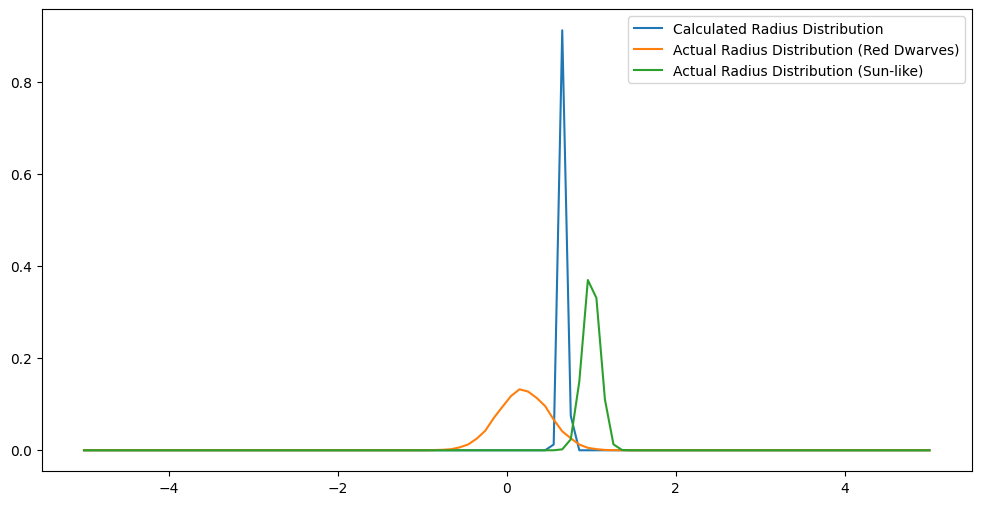

[0.6021706  0.74210185 0.6115302  ... 0.5724547  0.6132368  0.57325566]


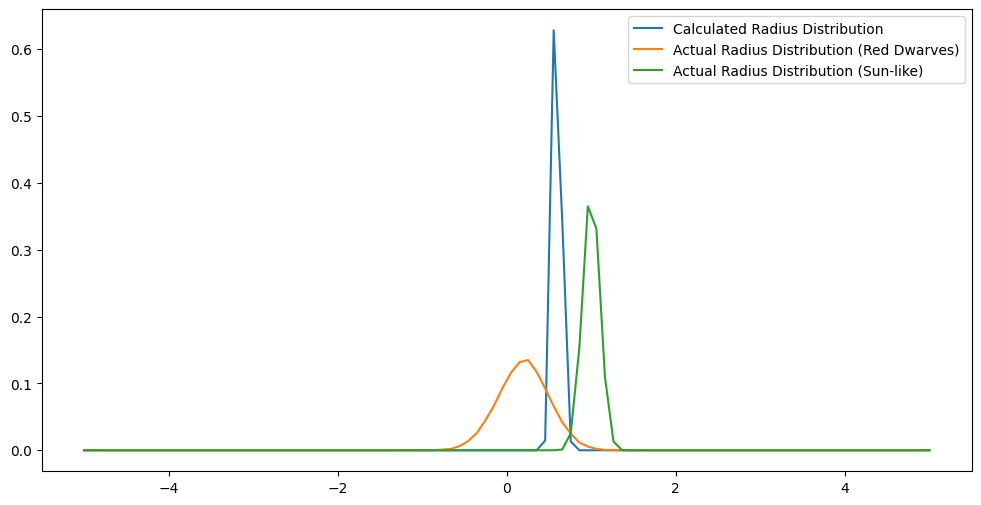

[0.88603216 0.5920671  0.36928537 ... 0.3197225  0.47612682 0.92524844]


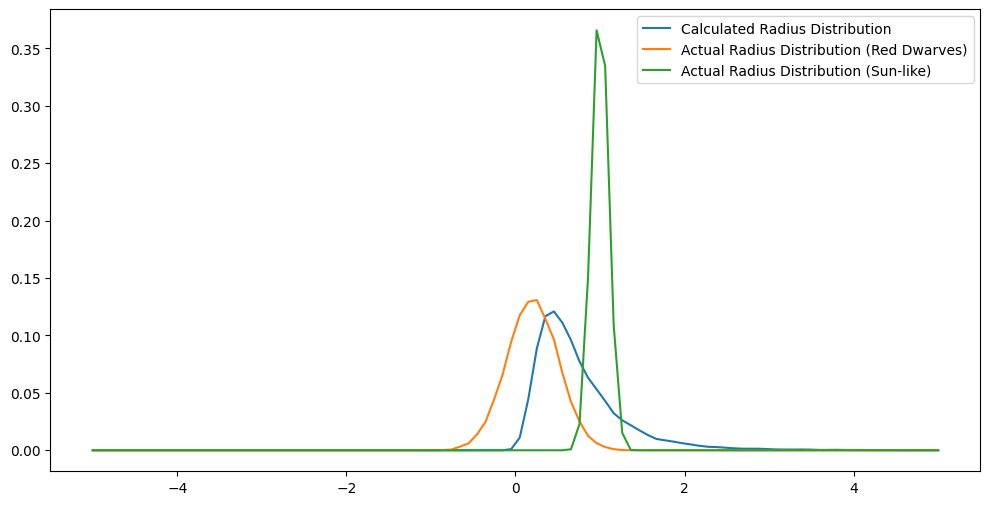

In [ ]:
for i, star in enumerate(star_types_radius):
    key, subkey = jax.random.split(key)
    num_samples = int(total_samples * 1.0/7.0)

    star_samples_rad = jax.random.normal(subkey, (num_samples,)) * params["rad_stds"][i] + params["rad_means"][i]
    star_samples_rad = 10**star_samples_rad
    print(star_samples_rad)
    #star_samples_rad = jnp.clip(star_samples_rad, max(1e-5, params["rad_means"][i] - params["rad_stds"][i]), max(1e-5, params["rad_means"][i] + params["rad_stds"][i]))
    #star_samples_rad = jnp.log10(star_samples_rad)
    #star_samples_rad = skew_normal(star_samples_rad, key, params['rad_skews'][i])

    star_temp = star_types_temperature[i]

    star_samples_temp = jax.random.normal(subkey, (num_samples,)) * params["temp_stds"][i] + params["temp_means"][i]
    #star_samples_temp = jnp.clip(star_samples_temp, max(1e-5, params["temp_means"][i] - params["temp_stds"][i]), max(1e-5, params["temp_means"][i] + params["temp_stds"][i]))
    #star_samples_temp = jnp.log10(star_samples_temp)
    #star_samples_temp = skew_normal(star_samples_temp, key, params['temp_skews'][i])

    #star_samples = transform(star_samples_rad, star_samples_temp)

    PDFS.append(jax.scipy.stats.gaussian_kde(star_samples_rad))
    star_samples_rad = jax.random.normal(subkey, (num_samples,)) * 0.3 + 0.2
    kde_true = jax.scipy.stats.gaussian_kde(star_samples_rad)(x)

    star_samples_rad2 = jax.random.normal(subkey, (num_samples,)) * 0.1 + 1.0
    kde_true2 = jax.scipy.stats.gaussian_kde(star_samples_rad2)(x)

    kde_radii = PDFS[-1](x)

    p = kde_radii
    q = kde_true
    r = kde_true2

    p = p / jnp.sum(p)
    q = q / jnp.sum(q)
    r = r / jnp.sum(r)

    plt.figure(figsize=(12, 6))
    plt.plot(x, p, label='Calculated Radius Distribution')
    plt.plot(x, q, label='Actual Radius Distribution (Red Dwarves)')
    plt.plot(x, r, label='Actual Radius Distribution (Sun-like)')
    plt.legend()
    plt.show()
